# Ultrasonic vocalizations from mice
Mouse USVs do not cluster into discrete types but lie on a continuous, low-dimensional manifold.

We here closely follow the procedure described in Sainburg et al. (2020): Finding, visualizing, and quantifying latent structure across (see code on [github](https://github.com/timsainb/avgn_paper)).

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa.feature
import colorcet as cc
import umap
import scipy.cluster.vq
import deepss_unsupervised.spec_utils
from io import BytesIO
import urllib.request

%config InlineBackend.figure_format = 'jpg'  # smaller mem footprint for page
plt.style.use('ncb.mplstyle')

## Download audio data
Data kindly provided by Kurt Hammerschmidt and published in A Ivanenko, P Watkins, MAJ van Gerven, K Hammerschmidt, B Englitz (2020) Classifying sex and strain from mouse ultrasonic vocalizations using deep learning. PLoS Comput Biol 16(6): e1007918.


In [8]:
url = 'https://github.com/janclemenslab/deepss_unsupervised/releases/download/v0.4/mice.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
samplerate = d['samplerate']
recording = d['recording']
syllable_onsets = d['syllable_onsets']
syllable_offsets = d['syllable_offsets']

## Pre-processing
Compute the spectrogram

(128,)


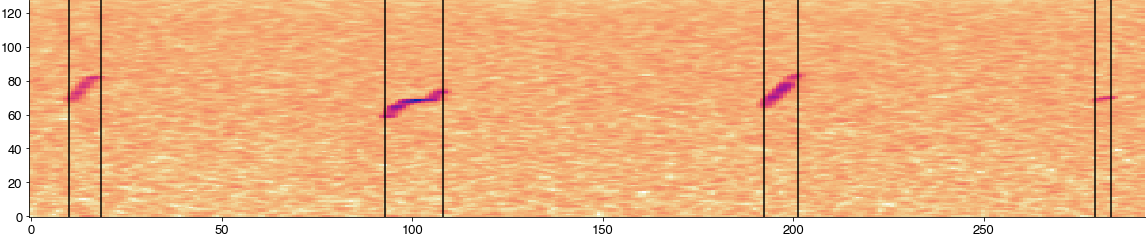

In [9]:
n_fft = 2048
hop_length = int(samplerate / 1000)

specgram = librosa.feature.melspectrogram(recording, sr=samplerate, n_fft=n_fft, hop_length=hop_length, power=1, fmin=40_000)
freqs = librosa.core.mel_frequencies(n_mels=specgram.shape[0], fmin=40_000, fmax=int(samplerate/2), htk=False)
sm = np.median(specgram, axis=1)
print(sm.shape)

plt.figure(figsize=(20, 4))
plt.imshow(np.log2(specgram[:, int(syllable_onsets[1]/hop_length)-10:int(syllable_offsets[4]/hop_length)+10]), cmap='cet_CET_L17')
for onset, offset in zip(syllable_onsets[1:5], syllable_offsets[1:5]):
    plt.axvline((onset-syllable_onsets[1])/hop_length + 10, c='k')
    plt.axvline((offset-syllable_onsets[1])/hop_length + 10, c='k')

Extract and threshold syllables from spectrogram

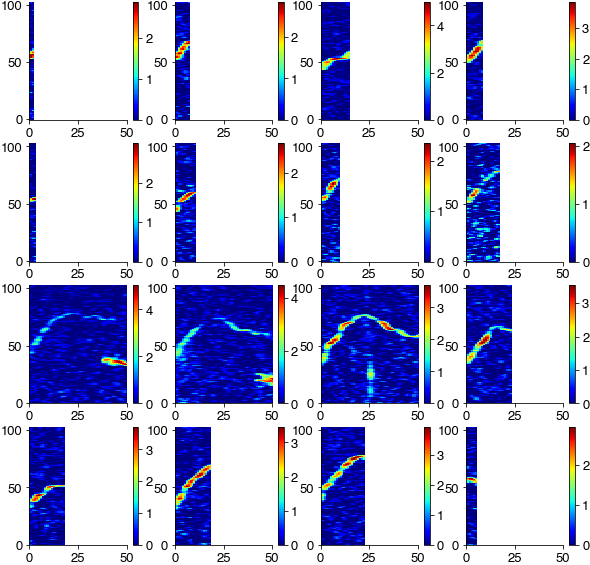

In [10]:
specs = [] 

plt.figure(figsize=(10, 10))
for cnt, (onset, offset) in enumerate(zip(syllable_onsets, syllable_offsets)):
    spec = np.log2(specgram[:, int(onset/hop_length):int(offset/hop_length)]/ sm[:,np.newaxis])
    spec = spec[15:-10, :]
    spec[spec<0] = 0
    specs.append(spec)
    try:
        plt.subplot(4,4,cnt+1)
        plt.imshow(spec, cmap='jet')
        plt.xlim(0, 50)
        plt.colorbar()
    except:
        pass

Log-scale the time axis to reduce differences in syllable duration and zero-pad all syllables to the same duration

46


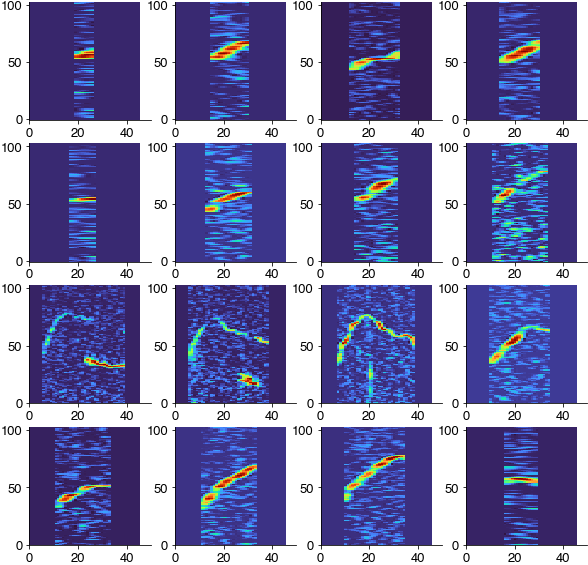

In [11]:
spec_rs = [deepss_unsupervised.spec_utils.log_resize_spec(spec, scaling_factor=8) for spec in specs]

max_len = np.max([spec.shape[1] for spec in spec_rs])
print(max_len)
spec_rs = [deepss_unsupervised.spec_utils.pad_spec(spec, pad_length=max_len) for spec in spec_rs]
plt.figure(figsize=(10, 10))
for cnt, spc in enumerate(spec_rs[:16]):
    plt.subplot(4,4,cnt+1)
    plt.imshow(spc, cmap='turbo')
    plt.xlim(0, 50)


Center spectra around their peak frequencies

In [12]:
offset = 20
spec_rs_c = [deepss_unsupervised.spec_utils.center_spec(spec, halfwidth=offset) for spec in spec_rs]
spec_rs_c = np.array(spec_rs_c)

Flatten 2D [time x freq] spectrograms to 1D feature vectors

In [13]:
spec_flat = [spec.ravel() for spec in spec_rs_c]
spec_flat = np.array(spec_flat)

## Dimensionality reduction and clustering
Embed the feature vectors into a 2D space using [UMAP](https://umap-learn.readthedocs.io/) and group similar syllables usign [kmeans](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans2.html).

In [14]:
out = umap.UMAP(min_dist=0.5).fit_transform(spec_flat)
k_centroid, k_labels = scipy.cluster.vq.kmeans2(out, k=40)

## Plot results
Syllable spectrograms embedded into a 2D space  (left) and colored by the unsupervised cluster labels (right). Syllables do not fall into separate groups, but can be grouped by similarity using clustering.

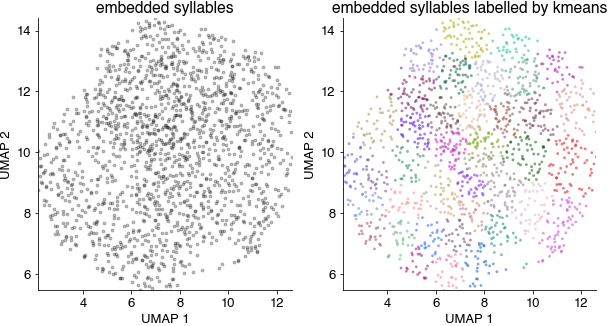

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(out[:,0], out[:,1], c='k', alpha=0.25, s=8)
plt.axis('tight')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('embedded syllables')

plt.subplot(122)
plt.scatter(out[:,0], out[:,1], c=k_labels, cmap='cet_glasbey_dark', alpha=0.5, s=8, edgecolor='none')
plt.axis('tight')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('embedded syllables labelled by kmeans')

plt.show()

Average spectrograms of the syllables in each cluster, plotted at the position of the respective cluster centroid in UMAP space. Spectrotemporal features vary smoothly within this space, suggesting that mouse USVs lie on a low-dimensional manifold.

Text(0, 0.5, 'UMAP 2')

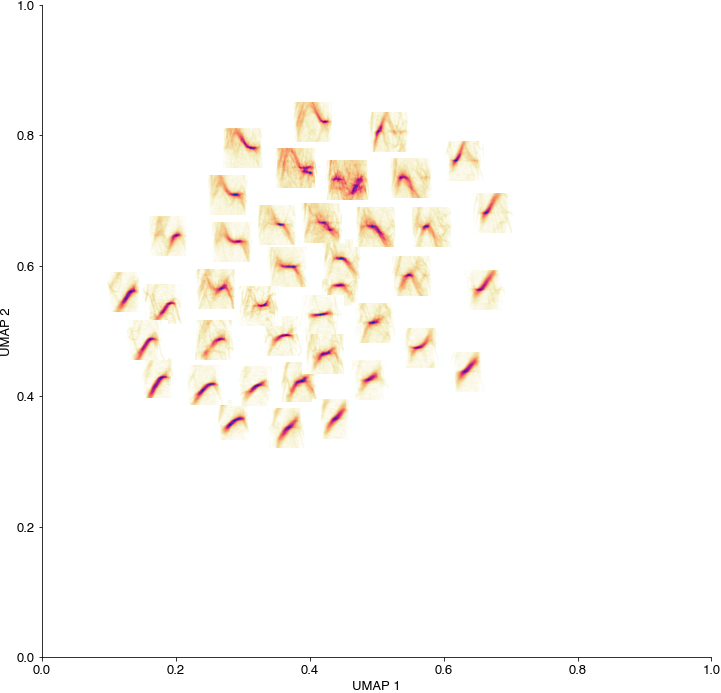

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()
for cnt, (centroid, label) in enumerate(zip(k_centroid, np.unique(k_labels))):
    idx = np.where(k_labels==label)[0]
    X = np.mean(spec_rs_c[idx], axis=0)
    fig.figimage(X=X, xo=centroid[0]*40, yo=centroid[1]*40, cmap='cet_CET_L17')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')